# Turbulence Super-Resolution - Vorticity Visualization

Visualize super-resolution results using vorticity field computed from u and v velocity components.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import yaml

from swin_sr import SwinSR
from dataset import TurbulenceSRDataset

%matplotlib inline
plt.rcParams['figure.dpi'] = 100


In [ ]:
# Load configuration from YAML
class DictObject:
    """Convert dictionary to object with attribute access"""
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            if isinstance(value, dict):
                setattr(self, key, DictObject(value))
            else:
                setattr(self, key, value)
    
    def __getitem__(self, key):
        return getattr(self, key)

def load_config(config_path='config.yaml'):
    """Load configuration from YAML file"""
    with open(config_path, 'r') as f:
        config_dict = yaml.safe_load(f)
    
    # Flatten the nested structure for easier access
    config = DictObject({})
    
    # Data config
    if 'data' in config_dict:
        for key, value in config_dict['data'].items():
            setattr(config, key, value)
    
    # Model config
    if 'model' in config_dict:
        config.model = config_dict['model']
    
    # Training config
    if 'training' in config_dict:
        for key, value in config_dict['training'].items():
            setattr(config, key, value)
    
    # Loss config
    if 'loss' in config_dict:
        for key, value in config_dict['loss'].items():
            setattr(config, key, value)
    
    # Logging config
    if 'logging' in config_dict:
        for key, value in config_dict['logging'].items():
            setattr(config, key, value)
    
    # Reproducibility config
    if 'reproducibility' in config_dict:
        for key, value in config_dict['reproducibility'].items():
            setattr(config, key, value)
    
    # Device config
    if 'device' in config_dict:
        config.device = config_dict['device']
    
    return config

Config = load_config()

## 1. Setup and Load Model


In [ ]:
# Configuration
CHECKPOINT_PATH = 'experiments/swinsr_x8/checkpoints/best_model.pth'
DEVICE = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_SAMPLES = 3  # Number of samples to visualize

print(f"Device: {DEVICE}")
print(f"Checkpoint: {CHECKPOINT_PATH}")


Device: cpu
Checkpoint: experiments/swinsr_x8/checkpoints/best_model.pth


In [ ]:
# Load model
def load_model(checkpoint_path, device):
    """Load trained model from checkpoint"""
    print(f"Loading model from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model = SwinSR(**Config.model)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✓ Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
    if 'val_loss' in checkpoint:
        print(f"  Validation loss: {checkpoint['val_loss']:.6f}")
    
    return model

model = load_model(CHECKPOINT_PATH, DEVICE)


Loading model from experiments/swinsr_x8/checkpoints/best_model.pth...
✓ Model loaded from epoch 1
  Validation loss: 0.026207


## 2. Load Test Data and Run Inference


In [ ]:
# Create test dataset
test_dataset = TurbulenceSRDataset(
    root=Config.data_root,
    upscale=Config.upscale_factor,
    split='test',
    normalize=Config.normalize_data
)

test_loader = DataLoader(
    test_dataset,
    batch_size=NUM_SAMPLES,
    shuffle=True,
    num_workers=0
)

print(f"Test dataset size: {len(test_dataset)}")


Loading all 1 files for split='test' into memory...
Total samples in 'test' split: 2048
Test dataset size: 2048


In [ ]:
# Get test samples and run inference
lr_batch, hr_batch = next(iter(test_loader))

print(f"Low-res shape: {lr_batch.shape}")
print(f"High-res shape: {hr_batch.shape}")

# Run inference
with torch.no_grad():
    lr_batch = lr_batch.to(DEVICE)
    sr_batch = model(lr_batch)
    sr_batch = sr_batch.cpu()
    lr_batch = lr_batch.cpu()

print(f"Super-res shape: {sr_batch.shape}")


Low-res shape: torch.Size([3, 2, 32, 32])
High-res shape: torch.Size([3, 2, 256, 256])
Super-res shape: torch.Size([3, 2, 256, 256])


In [ ]:
# Denormalize data
if Config.normalize_data:
    lr_np = np.array([test_dataset._denormalize(lr_batch[i]) for i in range(lr_batch.shape[0])])
    sr_np = np.array([test_dataset._denormalize(sr_batch[i]) for i in range(sr_batch.shape[0])])
    hr_np = np.array([test_dataset._denormalize(hr_batch[i]) for i in range(hr_batch.shape[0])])
else:
    lr_np = lr_batch.permute(0, 2, 3, 1).numpy()
    sr_np = sr_batch.permute(0, 2, 3, 1).numpy()
    hr_np = hr_batch.permute(0, 2, 3, 1).numpy()

print(f"LR shape: {lr_np.shape}")
print(f"SR shape: {sr_np.shape}")
print(f"HR shape: {hr_np.shape}")


LR shape: (3, 32, 32, 2)
SR shape: (3, 256, 256, 2)
HR shape: (3, 256, 256, 2)


## 3. Compute Vorticity

Vorticity is computed as: ω = ∂v/∂x - ∂u/∂y


In [ ]:
def compute_vorticity(u, v):
    """
    Compute vorticity from u and v velocity components on a 2*pi periodic domain.
    
    Args:
        u: u-velocity (H, W)
        v: v-velocity (H, W)
    
    Returns:
        vorticity: ω = ∂v/∂x - ∂u/∂y
    """
    H, W = u.shape
    
    # Calculate grid spacing
    dy = (2 * np.pi) / H  # Spacing in y-direction (axis 0)
    dx = (2 * np.pi) / W  # Spacing in x-direction (axis 1)
    
    # Compute gradients using the physical spacing
    # np.gradient(f, dy, dx) returns (gradient_y, gradient_x)
    
    # For ω = ∂v/∂x - ∂u/∂y:
    
    # 1. We need ∂v/∂x, which is the gradient of v along axis 1 (x-direction)
    _, dv_dx = np.gradient(v, dy, dx)
    
    # 2. We need ∂u/∂y, which is the gradient of u along axis 0 (y-direction)
    du_dy, _ = np.gradient(u, dy, dx)
    
    vorticity = dv_dx - du_dy
    return vorticity

# Compute vorticity for all samples
vort_lr = np.array([compute_vorticity(lr_np[i, :, :, 0], lr_np[i, :, :, 1]) for i in range(NUM_SAMPLES)])
vort_sr = np.array([compute_vorticity(sr_np[i, :, :, 0], sr_np[i, :, :, 1]) for i in range(NUM_SAMPLES)])
vort_hr = np.array([compute_vorticity(hr_np[i, :, :, 0], hr_np[i, :, :, 1]) for i in range(NUM_SAMPLES)])

print(f"Vorticity LR shape: {vort_lr.shape}")
print(f"Vorticity SR shape: {vort_sr.shape}")
print(f"Vorticity HR shape: {vort_hr.shape}")


Vorticity LR shape: (3, 32, 32)
Vorticity SR shape: (3, 256, 256)
Vorticity HR shape: (3, 256, 256)


## 4. Visualize Vorticity: 2×2 Grid (Low-Res, True, Predicted, Difference)


In [ ]:
def plot_vorticity_2x2(vort_lr, vort_sr, vort_hr, sample_idx=0, levels=30):
    """
    Plot 2x2 grid: Low-Res (upsampled), True HR, Predicted SR, Difference
    
    Args:
        vort_lr: Low-resolution vorticity (H_lr, W_lr)
        vort_sr: Super-resolution vorticity (H, W)
        vort_hr: High-resolution vorticity (H, W)
        sample_idx: Sample index
        levels: Number of contour levels
    """
    # Upsample LR for visualization
    vort_lr_upsampled = np.kron(vort_lr, np.ones((Config.upscale_factor, Config.upscale_factor)))
    
    # Compute difference
    difference = vort_sr - vort_hr
    
    # Find global min/max for consistent color scale (excluding difference)
    vmin =  vort_hr.min()
    vmax = vort_hr.max()
    
    # Create 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Top-left: Low Resolution (upsampled)
    cf0 = axes[0, 0].contourf(vort_lr_upsampled, levels=levels, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[0, 0].set_title('Low Resolution (Upsampled)', fontsize=16, fontweight='bold', pad=15)
    axes[0, 0].set_aspect('equal')
    axes[0, 0].axis('off')
    plt.colorbar(cf0, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    # Top-right: High Resolution (Ground Truth)
    cf1 = axes[0, 1].contourf(vort_hr, levels=levels, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[0, 1].set_title('True (Ground Truth)', fontsize=16, fontweight='bold', pad=15)
    axes[0, 1].set_aspect('equal')
    axes[0, 1].axis('off')
    plt.colorbar(cf1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Bottom-left: Super Resolution (Predicted)
    cf2 = axes[1, 0].contourf(vort_sr, levels=levels, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[1, 0].set_title('Predicted (Super-Resolution)', fontsize=16, fontweight='bold', pad=15)
    axes[1, 0].set_aspect('equal')
    axes[1, 0].axis('off')
    plt.colorbar(cf2, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # Bottom-right: Difference (SR - HR)
    cf3 = axes[1, 1].contourf(difference, levels=levels, cmap='seismic', 
                               vmin=-max(abs(difference.min()), abs(difference.max())),
                               vmax=max(abs(difference.min()), abs(difference.max())))
    axes[1, 1].set_title('Difference (Predicted - True)', fontsize=16, fontweight='bold', pad=15)
    axes[1, 1].set_aspect('equal')
    axes[1, 1].axis('off')
    plt.colorbar(cf3, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    # Compute error metrics
    mse = np.mean((vort_sr - vort_hr) ** 2)
    mae = np.mean(np.abs(vort_sr - vort_hr))
    rmse = np.sqrt(mse)
    
    # Add main title with metrics
    fig.suptitle(f'Vorticity Field - Sample {sample_idx}' + 
                 f'RMSE: {rmse:.6f}',
                 fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Plotting

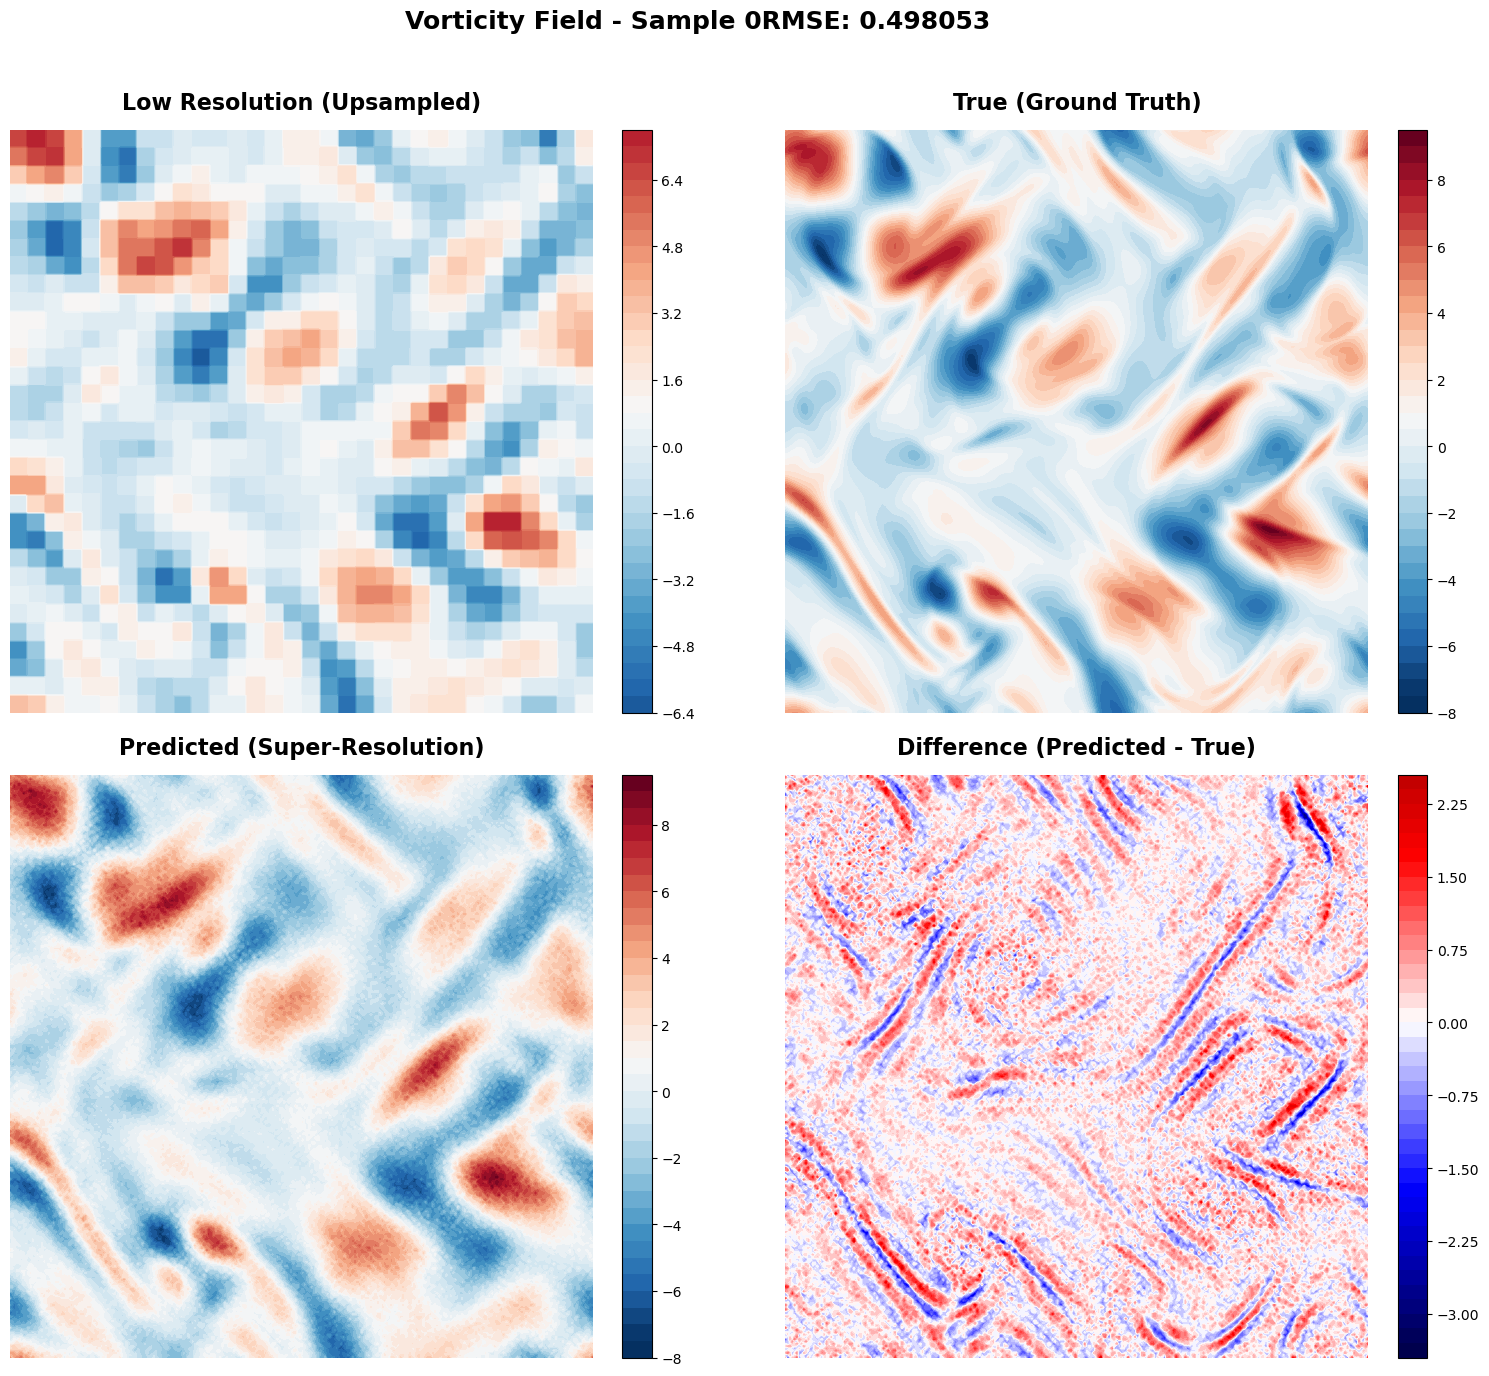

In [ ]:
plot_vorticity_2x2(vort_lr[0], vort_sr[0], vort_hr[0], sample_idx=0, levels=40)


### Sample 2


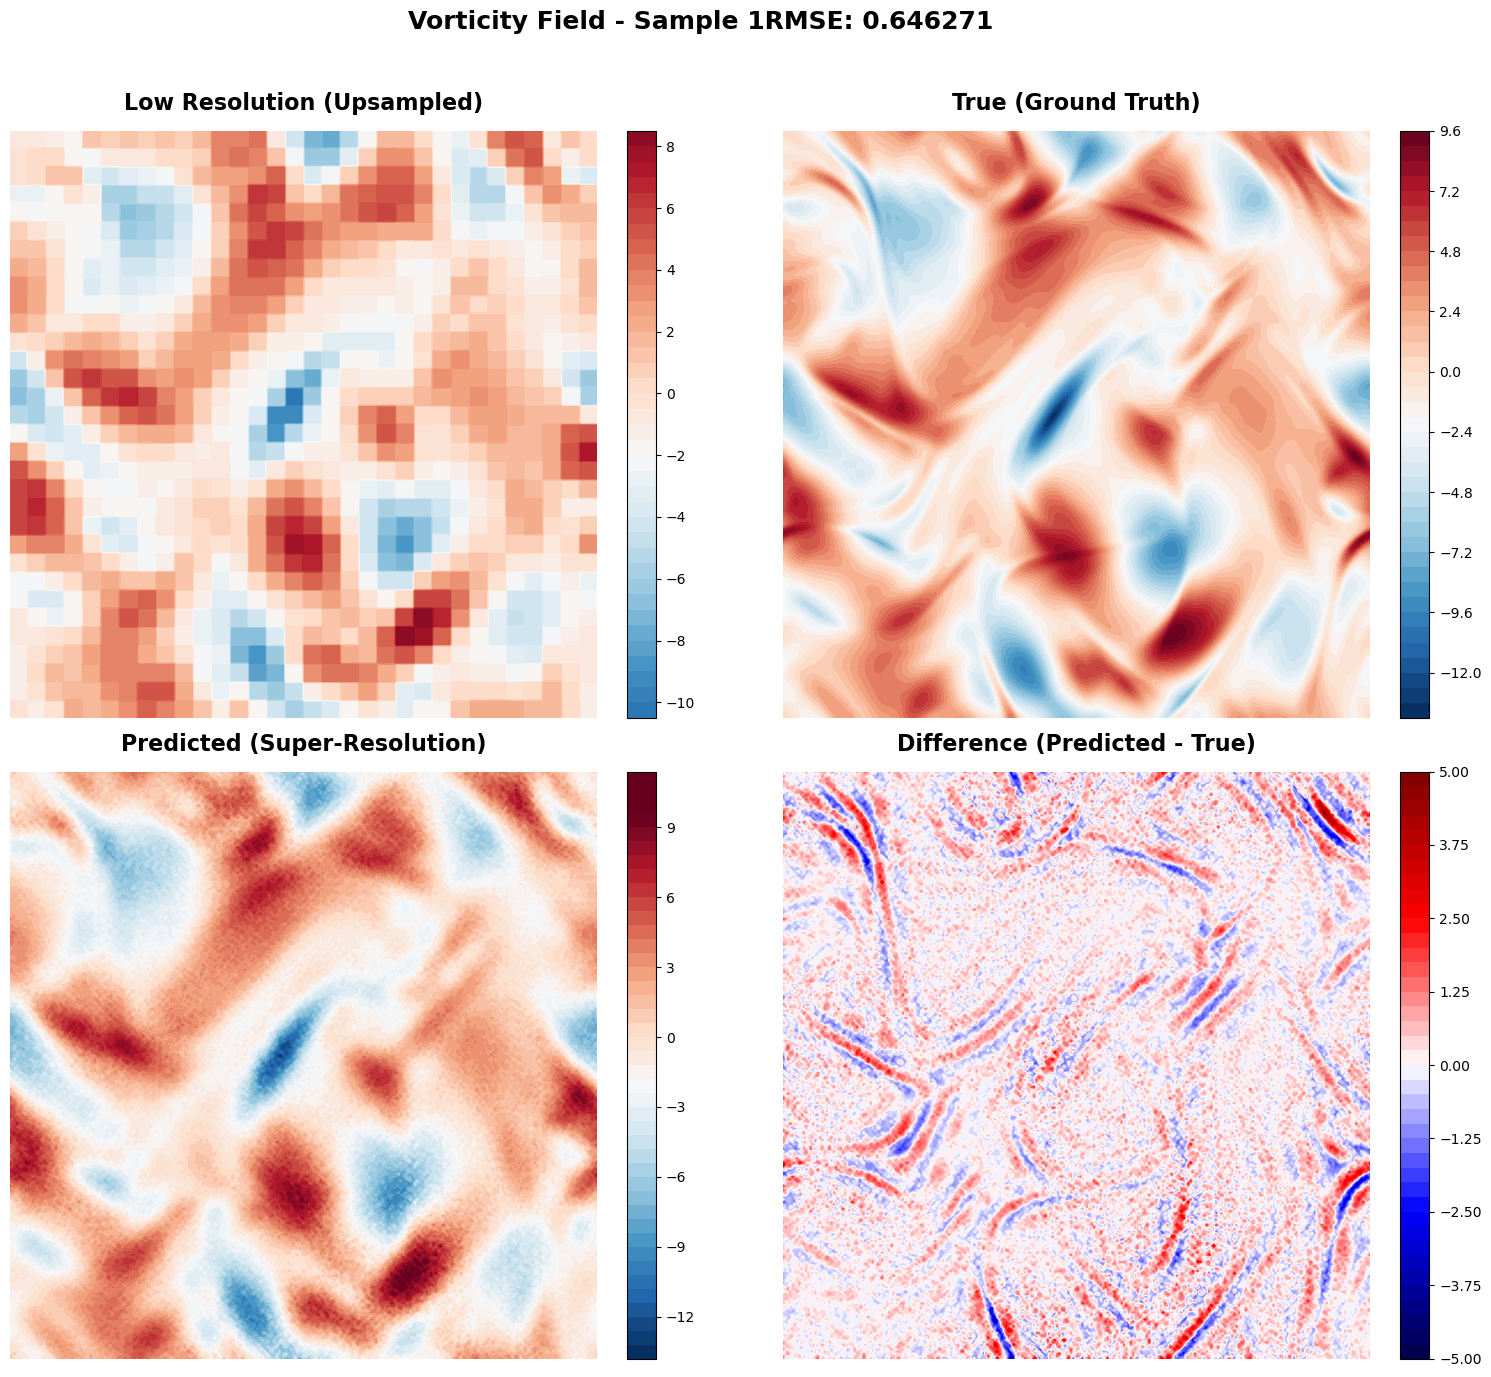

In [ ]:
plot_vorticity_2x2(vort_lr[1], vort_sr[1], vort_hr[1], sample_idx=1, levels=40)


### Sample 3


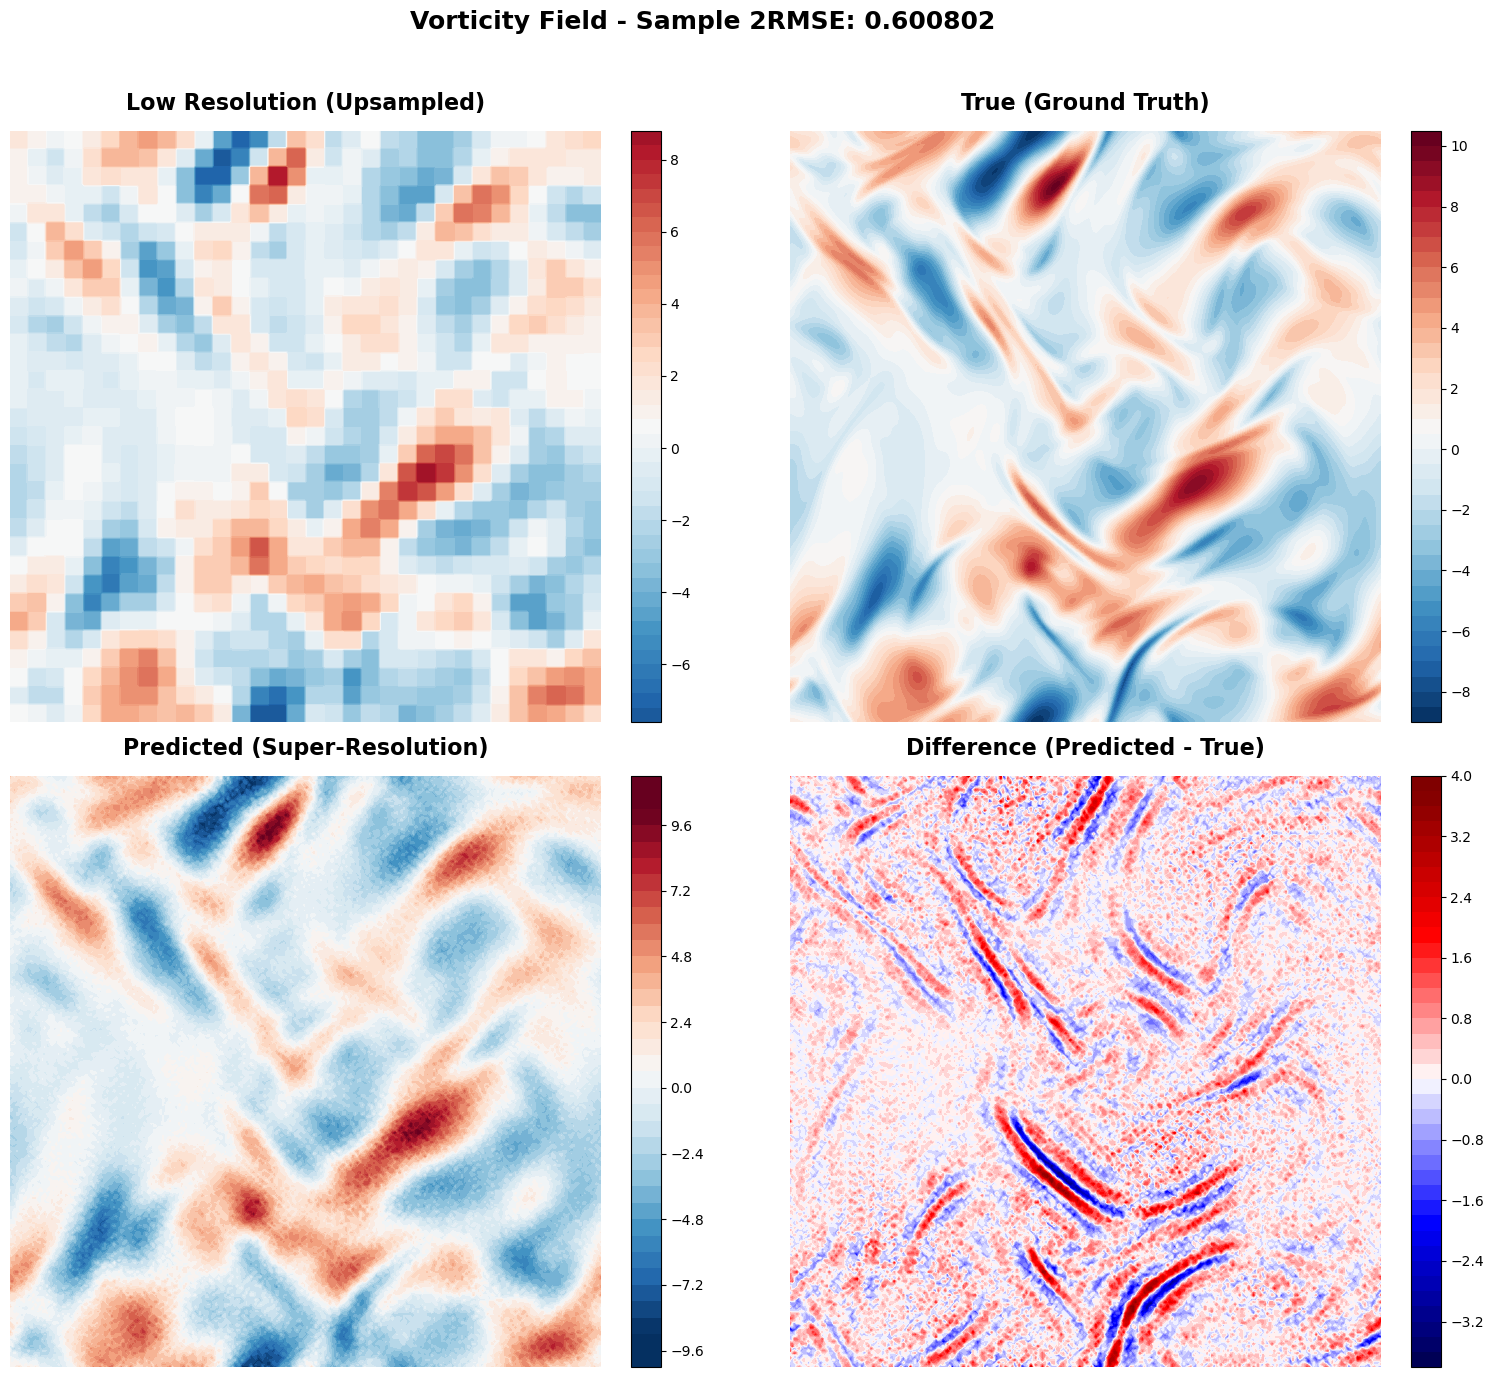

In [ ]:
plot_vorticity_2x2(vort_lr[2], vort_sr[2], vort_hr[2], sample_idx=2, levels=40)
